# Pre-processing data

In this notebook we talk about some of the functions and methods that are commonly used to deal with numeric and categorical columns in our data in preparation to doing machine learning. Without properly pre-processing the data, our ML algorithm will either fail to execute or execute but return results that are incorrect or incomplete. Since we haven't introduced machine learning yet, it's too early to show examples of how this can happen, but we will see examples in future lectures.

As usual, let's begin by reading some data. We want to read the data and find some ways to summarize the data.

In [1]:
import pandas as pd
import numpy as np
# you need to run this to produce visualizations in a jupyter notebook
%matplotlib inline
pd.options.display.max_columns = 40
pd.options.display.max_rows = 100
pd.options.display.precision = 3

LocalFile = '../../data/auto-mpg.csv'
UCI_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
url = UCI_url
auto = pd.read_csv(url, sep = '\s+', header = None, 
                   names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 
                            'acceleration', 'model year', 'origin', 'car_name'])
auto.head()

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_l/9c97q4ms35gg7r1hrlmv00cr0000ng/T/ipykernel_3828/2077771383.py:12: SyntaxWarning: invalid escape sequence '\s'
  auto = pd.read_csv(url, sep = '\s+', header = None,


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Let's check the dataframe size and column data types:

In [2]:
display(auto.shape)
display(auto.dtypes)

(398, 9)

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
car_name         object
dtype: object

We can see that we have quite a few numeric columns in here. Numeric columns can be **integer**, **float**, or **datetime** columns. However, we also need to be careful: a column like `cylinders` looks numeric, but probably should be treated as a categorical column. Why? Ask yourself which one of these two is more likely:

- do any kind of math with `cylinders`, such as taking the log of it, adding it to another column, or being interested in knowing the average number of cylinders?
- use cylinder as a grouping variable, such as wanting to see the average horsepower **by cylinder**?

We can probably agree that the second case is more likely. For this reason, we need to think of these types of variables as categorical despite them having numeric values.

Let's now look at some distributions for our numeric columns.

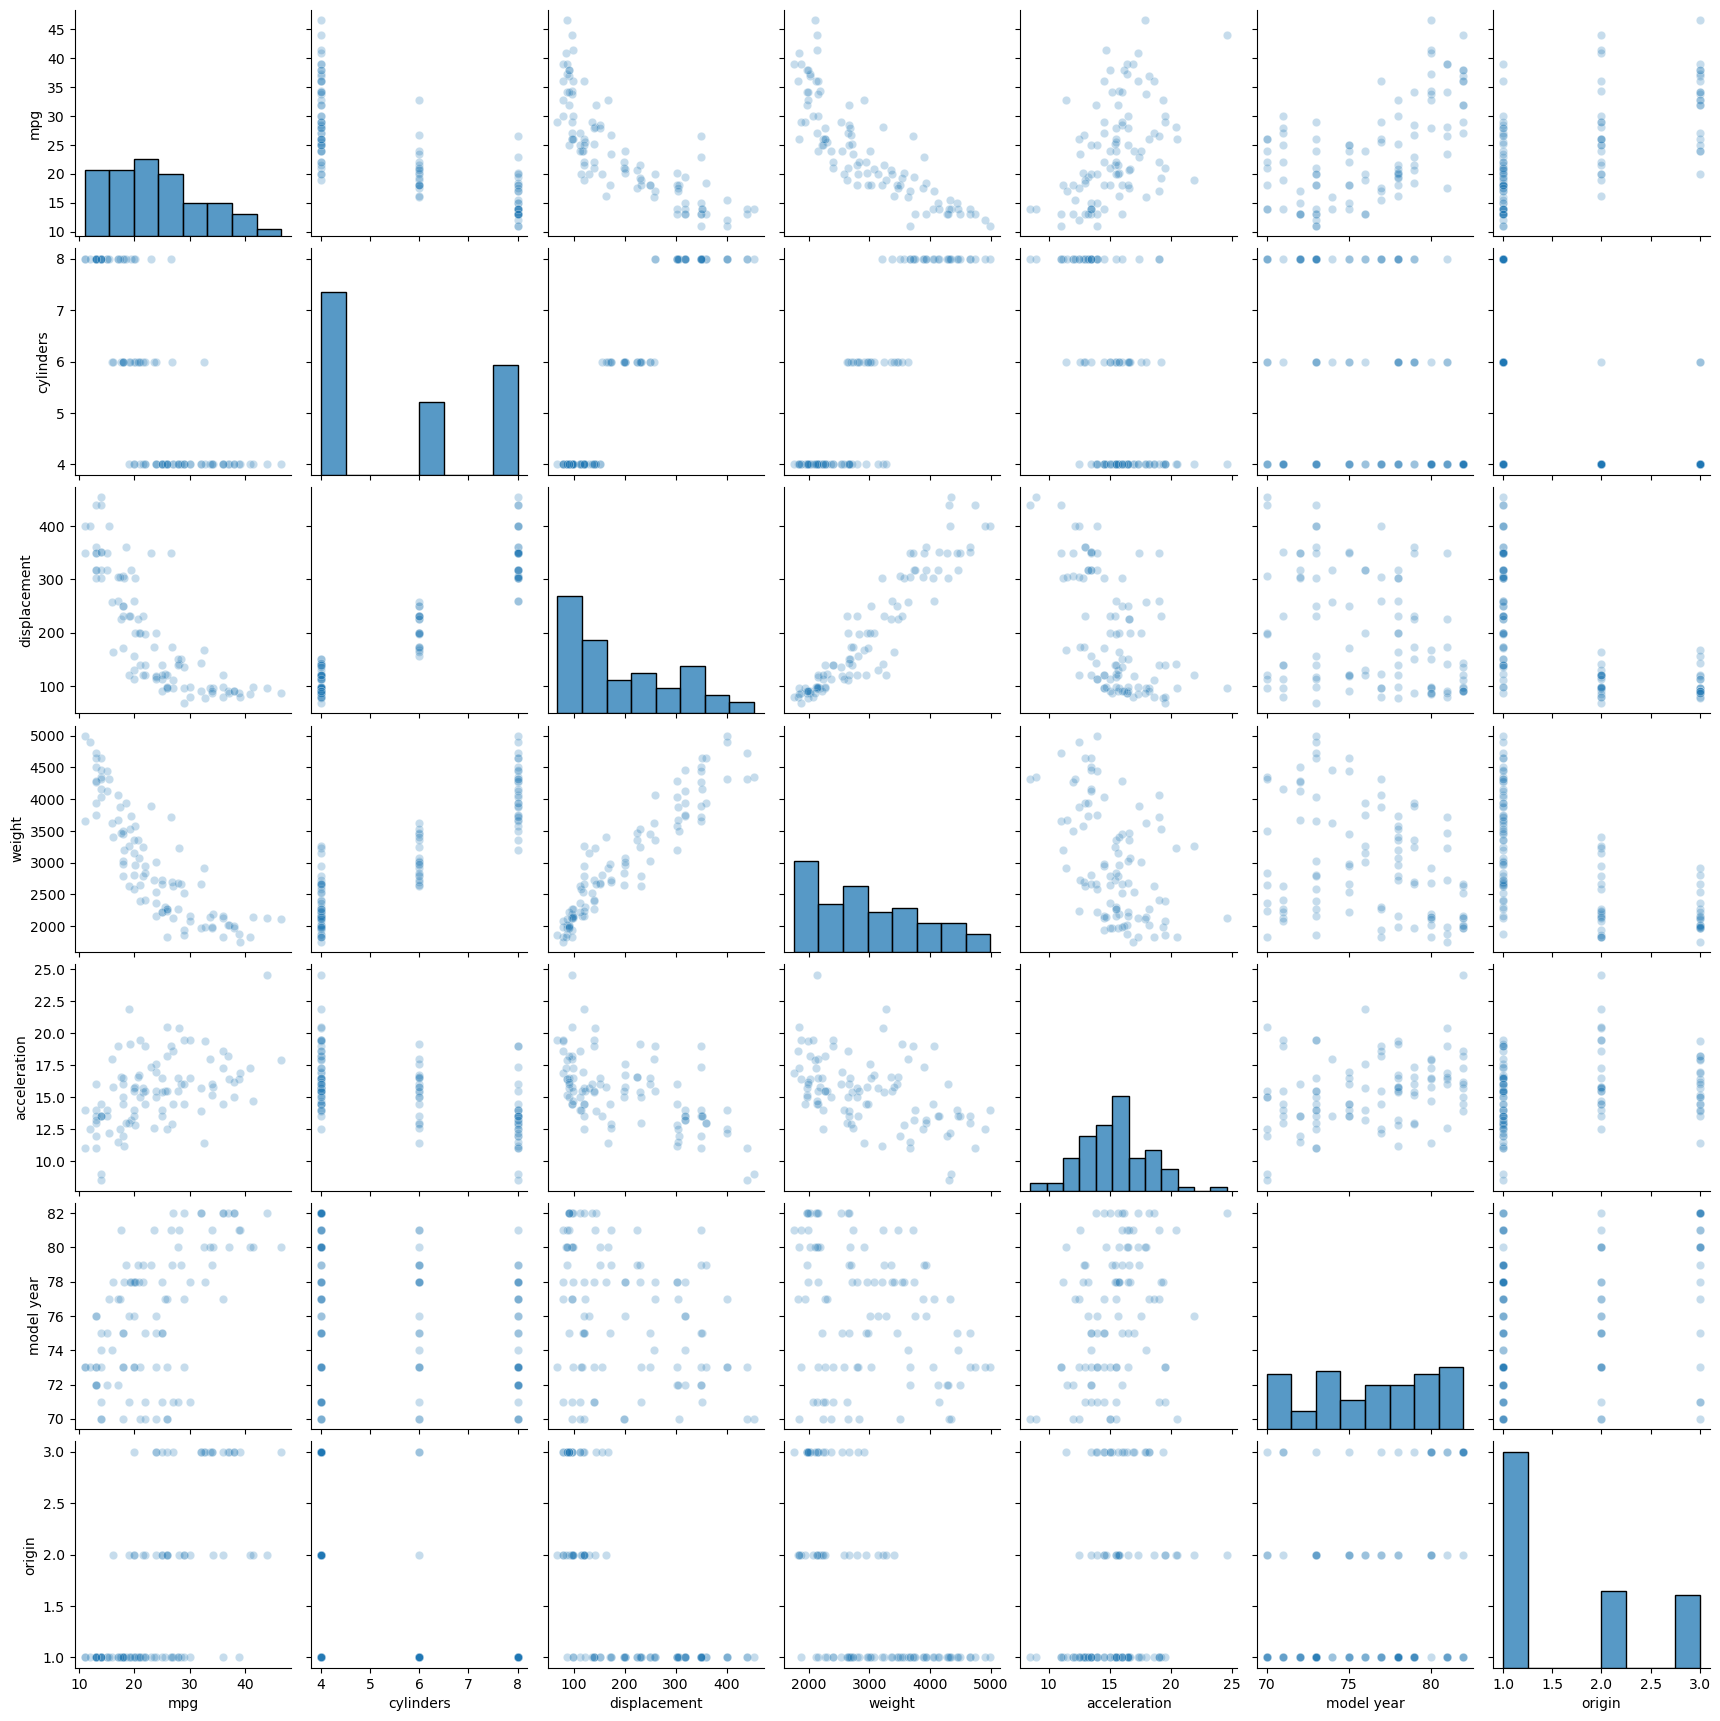

In [3]:
import seaborn as sns

sns.pairplot(auto.sample(100),  kind='scatter', plot_kws={'alpha':0.25});

None of the feature seem to have any extreme values. Let's check for missing values. To see if any columns in the data are missing, we can use the `isnull` method, followed by `any` where the `axis = 0` is used to ask if **any** of values **across columns** is null: `False` means that none is missing, and `True` means that at least one value is missing.

In [4]:
auto.isnull().any(axis = 0)

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
car_name        False
dtype: bool

Even better would be to use `sum` to get the count of values that are missing for each column.

In [5]:
auto.isnull().sum(axis = 0)

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car_name        0
dtype: int64

Note that all of this would work only if the missing data is properly marked as null. Often when reading external data sources, other conventions are used to mark data as missing, such as using `-999` for numeric data, or the string `NA` or `?` or the empty string for categorical data. Such values by default would not be picked up by `isnull`. So we would need to first recode them as `np.nan`.

### Exercise (8 minutes)

Let's illustrate the above point with an example, let's intentially introduce a few missing values in the data, but using characters that won't be recognized as such.

In [6]:
auto.loc[2, ['mpg', 'car_name']] = [-999, ""] # make mpg and car_name in the 3rd row NA
# Add zero to origin of 4th car
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,-999.0,8,318.0,150.0,3436.0,11.0,70,1,
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


We look for the following occurences to detect the missing values:
- inappropriate data types
- the length of strings in `car_name`
- outliers in numerical values
- A numerical value of zero (0) can be a stand-in for null.
- very common or very rare values:  Check number of unique values and if reasonable, review the values
- Unusual characters like question mark ("?"), blank (" "), empty (""), "x", "-"
  
How can we use a boolean indexer in `.loc` of `pandas` to find the missing values?

In [7]:
# Add code here 001
auto.loc[auto['mpg'] < 0,'mpg'], auto.loc[auto['car_name'] == "",'car_name']
# for row in auto.iterrows():
#     if row[1] < 0:
#         print(row)

(2   -999.0
 Name: mpg, dtype: float64,
 2    
 Name: car_name, dtype: object)

In [8]:
for t in auto.dtypes.items():
    print(t)

('mpg', dtype('float64'))
('cylinders', dtype('int64'))
('displacement', dtype('float64'))
('horsepower', dtype('O'))
('weight', dtype('float64'))
('acceleration', dtype('float64'))
('model year', dtype('int64'))
('origin', dtype('int64'))
('car_name', dtype('O'))


In [9]:
num_cols = [col for col,type in auto.dtypes.items() if type != 'object']
num_cols

['mpg',
 'cylinders',
 'displacement',
 'weight',
 'acceleration',
 'model year',
 'origin']

In [10]:
(auto.select_dtypes(['int64','float64']) < 0).any()

mpg              True
cylinders       False
displacement    False
weight          False
acceleration    False
model year      False
origin          False
dtype: bool

- Replace the above missing values with `np.nan`

In [11]:
# Add code here 002
auto.loc[auto['mpg'] < 0,'mpg'] = np.nan
auto.loc[auto['car_name'] == "",'car_name'] = np.nan

- Now show any rows in the data that have any missing values. HINT: you will need to use `any` with `axis = 1`.

In [12]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,NaN,8,318.0,150.0,3436.0,11.0,70,1,NaN
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [13]:
# Add code here 003
auto.loc[auto.isnull().any(axis=1),:]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car_name
2,NaN,8,318.0,150.0,3436.0,11.0,70,1,NaN


We also can see from the scatter plot matrix that `weight` and `displacement` have a **positive relationship**.  A positive relationship means that as one goes up, so does the other. We may wonder if `cylinders` plays a part.

- Plot the scatter plot between `weight` and `displacement`, color-coded by `cylinders`.

In [14]:
# Add code here 004

- Obtain some basic summary statistics for the columns in `auto`. HINT: Use `describe`.

In [15]:
# Add code here 005

Notice that the result of `describe` itself looks looks like a `pandas` `DataFrame` or `Series`. That means that if we wanted to extract certain pieces out of it, we should be able to do it using the methods we learned for working with `DataFrame` objects.

- Extract the mean and standard deviation for acceleration from the results above and store them in variables called `acc_mean` and `acc_std`. Then print a statement that states what the mean and standard deviations are.

In [16]:
# Add code here 006

### End of exercise

There are other functions we can use to get additional summary statistics from the data. For example, notice that `describe` only shows us the 25th, 50th, and 75th **percentiles**. The $p$th percentile is **a value such that $p$ percent of the data is below that value**, which means the remaining $1-p$ percent of the data is above that value. For example, if the 25th percentile for acceleration `mpg` is 17.5, then 25 percent of cars in our data have `mpg` below 17.0. The 50th percentile is also known as the **median**.

Looking at percentiles helps us get a feel for the distribution of the data. For example, looking at very low or very high percentiles can help us identify **outliers** or **extreme values**. We can use the `quantile` method to get any percentile we want:

In [17]:
auto.mpg.quantile(q = [0, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1])

0.00     9.000
0.01    11.000
0.05    13.000
0.25    17.500
0.50    23.000
0.75    29.000
0.95    37.040
0.99    43.424
1.00    46.600
Name: mpg, dtype: float64

Now let's see how we can obtain these same summary statistics, but grouped by `cylinders`. There is already one way we know how to do that: we can first subset the data by `cylinders == 3` and run the summary statistic, then do the same for `cylinders == 4`, etc.

In [18]:
auto.loc[auto['cylinders'] == 3, :].describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,4.000,4.0,4.0,4.000,4.00,4.000,4.0
mean,20.550,3.0,72.5,2398.500,13.25,75.500,3.0
std,2.565,0.0,5.0,247.566,0.50,3.697,0.0
min,18.000,3.0,70.0,2124.000,12.50,72.000,3.0
25%,18.750,3.0,70.0,2278.500,13.25,72.750,3.0
50%,20.250,3.0,70.0,2375.000,13.50,75.000,3.0
75%,22.050,3.0,72.5,2495.000,13.50,77.750,3.0
max,23.700,3.0,80.0,2720.000,13.50,80.000,3.0


But of course the above way is tedious. Instead, we can use the `groupby` method to do it all at once. For example, here's the average of each column grouped by `cylinders`.

In [19]:
auto.groupby('cylinders').mpg.mean()

cylinders
3    20.550
4    29.287
5    27.367
6    19.986
8    14.933
Name: mpg, dtype: float64

A slightly confusing thing happens if we use `describe` instead of `mean`:

In [20]:
results_all = auto.groupby('cylinders').describe()
print("dataframe with multi-level columns:")
display(results_all)

dataframe with multi-level columns:


mpg                                                 displacement  \
           count    mean    std   min    25%    50%    75%   max        count   
cylinders                                                                       
3            4.0  20.550  2.565  18.0  18.75  20.25  22.05  23.7          4.0   
4          204.0  29.287  5.710  18.0  25.00  28.25  33.00  46.6        204.0   
5            3.0  27.367  8.228  20.3  22.85  25.40  30.90  36.4          3.0   
6           84.0  19.986  3.807  15.0  18.00  19.00  21.00  38.0         84.0   
8          102.0  14.933  2.834   9.0  13.00  14.00  16.00  26.6        103.0   

                                                                weight  \
              mean     std    min     25%    50%     75%    max  count   
cylinders                                                                
3           72.500   5.000   70.0   70.00   70.0   72.50   80.0    4.0   
4          109.797  21.512   68.0   91.00  105.0  121.25  156.0  204.0   
5          145.000  33.287  121.0  126.00  131.0  157.00  183.0    3.0   
6          218.143  32.294  145.0  199.75  228.0  250.00  262.0   84.0   
8          345.010  46.776  260.0  305.00  350.0  360.00  455.0  103.0   

                                      ... acceleration                    \
               mean      std     min  ...          25%   50%   75%   max   
cylinders                             ...                                  
3          2398.500  247.566  2124.0  ...       13.250  13.5  13.5  13.5   
4          2308.127  347.094  1613.0  ...       14.800  16.2  18.0  24.8   
5          3103.333  374.344  2830.0  ...       17.900  19.9  20.0  20.1   
6          3198.226  332.297  2472.0  ...       15.075  16.1  17.6  21.0   
8          4114.718  448.833  3086.0  ...       11.500  13.0  14.0  22.2   

          model year                                                origin  \
               count    mean    std   min    25%   50%    75%   max  count   
cylinders                                                                    
3                4.0  75.500  3.697  72.0  72.75  75.0  77.75  80.0    4.0   
4              204.0  77.074  3.753  70.0  74.00  78.0  80.00  82.0  204.0   
5                3.0  79.000  1.000  78.0  78.50  79.0  79.50  80.0    3.0   
6               84.0  75.929  3.252  70.0  74.00  76.0  78.00  82.0   84.0   
8              103.0  73.903  3.021  70.0  72.00  73.0  76.00  81.0  103.0   

                                                  
            mean    std  min  25%  50%  75%  max  
cylinders                                         
3          3.000  0.000  3.0  3.0  3.0  3.0  3.0  
4          1.985  0.833  1.0  1.0  2.0  3.0  3.0  
5          2.000  0.000  2.0  2.0  2.0  2.0  2.0  
6          1.190  0.548  1.0  1.0  1.0  1.0  3.0  
8          1.000  0.000  1.0  1.0  1.0  1.0  1.0  

[5 rows x 48 columns]

The problem with the above table is that there's a lot of information packed in it. Each value of `cylinders` has its own row, which is fine. But the columns look like they have a hierarchical structure, which makes sense because we asked for many summary statistics for each column.

A pandas series is a 1-D collection of scalars.  A typical pandas dataframe is a 2-D collection of scalars.  `results_all` is a multi-level dataframe, which is a 3D collection of scalars.  The 3 Dimensions are:
1. Cylinder Values: [3, 4, 5, 6, 8]
2. Numeric Columns (except Cylinder): [mpg, displacement, weight, acceleration, model, year, origin]
3. Descriptive Statistics:  [count, mean, std, min, 25%, 50%, 75%, max]

So what if for example we wanted to look at the results for `acceleration` only. Turns out we can index the multi-level dataframe the same way we usually do:

In [21]:
print("One slice of a multi-level dataframe is a typical dataframe:")
display(results_all['acceleration'])

One slice of a multi-level dataframe is a typical dataframe:


,count,mean,std,min,25%,50%,75%,max
cylinders,,,,,,,,
3,4.0,13.250,0.500,12.5,13.250,13.5,13.5,13.5
4,204.0,16.601,2.382,11.6,14.800,16.2,18.0,24.8
5,3.0,18.633,2.369,15.9,17.900,19.9,20.0,20.1
6,84.0,16.263,2.021,11.3,15.075,16.1,17.6,21.0
8,103.0,12.955,2.225,8.0,11.500,13.0,14.0,22.2


The difference with before is that `results_all['acceleration']` isn't just a single column, but is itself a `DataFrame`. That's because `results_all` has hierarchical columns, so its columns are themselves `DataFrame` objects. So if we want to drill further down to a specific column, such as `std`, we need to go one level deeper to get the series for the standard deviations of acceleration by cylinder.  We can even drill down one more level and request the standard deviation of acceleration for 3-cylinder vehicles.

In [22]:
print("series for the standard deviations of acceleration by cylinder:")
display(results_all['acceleration']['std'])
print("###################")
print("scalar for the standard deviation of acceleration for 3-cylinder vehicles:")
display(results_all['acceleration']['std'][3])

series for the standard deviations of acceleration by cylinder:


cylinders
3    0.500
4    2.382
5    2.369
6    2.021
8    2.225
Name: std, dtype: float64

###################
scalar for the standard deviation of acceleration for 3-cylinder vehicles:


np.float64(0.5)

So far it looks like hierarchical columns are not that complicated. However, things do get a little confusing when we want to cross the hierarchy the other way around. For example, let's say we want to quickly compare the standard deviations of all our columns, grouped by `cylinders`. This information is in the above table, but how do we extract it?

It turns out that to do this, we need to use the `IndexSlice` function in `pandas`. Here how it works:
- we use `loc` to say which rows and columns we want
- we use `slice(None)` to say we want everything at a given hierarchy
- if we want to filter at any level of hierarchy, we provide the index we want to filter by

In [23]:
from pandas import IndexSlice as idx
results_all.loc[: , idx[:, 'std']] # results_all.loc[: , idx[:, ['std', 'mean']]]

,mpg,displacement,weight,acceleration,model year,origin
,std,std,std,std,std,std
cylinders,,,,,,
3,2.565,5.000,247.566,0.500,3.697,0.000
4,5.710,21.512,347.094,2.382,3.753,0.833
5,8.228,33.287,374.344,2.369,1.000,0.000
6,3.807,32.294,332.297,2.021,3.252,0.548
8,2.834,46.776,448.833,2.225,3.021,0.000


By the way, the same way that we can have hierarchical columns, we can also have hierarchical rows, more specifically hierachical row indexes. Examine the result generated by the cell below. Do see the hierarchical structure of the row index?

In [24]:
percentiles = np.arange(0, 1, 0.1)
auto.groupby('cylinders')[['mpg', 'displacement']].quantile(q = percentiles)

mpg  displacement
cylinders                         
3         0.0  18.00          70.0
          0.1  18.30          70.0
          0.2  18.60          70.0
          0.3  18.90          70.0
          0.4  19.50          70.0
          0.5  20.25          70.0
          0.6  21.00          70.0
          0.7  21.72          71.0
          0.8  22.38          74.0
          0.9  23.04          77.0
4         0.0  18.00          68.0
          0.1  23.00          85.0
          0.2  24.00          91.0
          0.3  26.00          97.0
          0.4  27.00          98.0
          0.5  28.25         105.0
          0.6  30.00         113.8
          0.7  32.00         120.1
          0.8  34.10         134.0
          0.9  37.00         140.0
5         0.0  20.30         121.0
          0.1  21.32         123.0
          0.2  22.34         125.0
          0.3  23.36         127.0
          0.4  24.38         129.0
          0.5  25.40         131.0
          0.6  27.60         141.4
          0.7  29.80         151.8
          0.8  32.00         162.2
          0.9  34.20         172.6
6         0.0  15.00         145.0
          0.1  16.06         168.0
          0.2  17.66         198.0
          0.3  18.00         200.0
          0.4  18.52         225.0
          0.5  19.00         228.0
          0.6  20.00         231.8
          0.7  20.62         232.0
          0.8  22.00         250.0
          0.9  23.85         250.0
8         0.0   9.00         260.0
          0.1  12.00         302.0
          0.2  13.00         304.0
          0.3  13.00         318.0
          0.4  14.00         318.0
          0.5  14.00         350.0
          0.6  15.00         350.0
          0.7  16.00         351.0
          0.8  16.98         400.0
          0.9  18.19         400.0

Hierarchical indexes are called `MultiIndex` in `pandas`. This is a more advanced topic and we will leave it at that for now.

### Exercise (7 minutes)

We saw how a histogram shows us counts for **evenly-sized** intervals of a numeric column. But what if we wanted to see counts for any intervals we specify, evenly-sized or not? Here's an example:

- Find out how many cars have `mpg` less than 18, between 18 and 25, and 25 or more? HINT: There are many ways of doing this, so to narrow it down a little do this:
  - use `loc` to limit data to the above ranges
  - use the `shape` method to get row counts

In [25]:
# Add code here 007
autos_under18 = auto[auto.mpg < 18]
autos_under25 = auto[(auto.mpg > 18) & (auto.mpg < 25)]
autos_over25 = auto[auto.mpg > 25]

print(autos_over25.shape,autos_under25.shape,autos_under18.shape)

(158, 9) (105, 9) (107, 9)


- How many rows were not counted because they did not fall into any of these intervals?

In [26]:
# Add code here 008
rows_count = autos_over25.shape[0] + autos_under25.shape[0] + autos_under18.shape[0]
rows_lost = auto.shape[0] - rows_count

print(f"total rows are {rows_count} compared to {auto.shape[0]} thus we lost {rows_lost}")

total rows are 370 compared to 398 thus we lost 28


There is another, much faster way to solve the exercise above: 

- Use the `pd.cut` function to bin `mpg` and specify `[0, 18, 25, 100]` as the cut-offs (the `bins` argument). Store the results as a new column in the data called `mpg_cat`.

In [27]:
# Add code here 009
mpg_cat = pd.cut(auto['mpg'], [0,18,25,100])

- Use `value_counts` to get counts for `mpg_cat`.

In [28]:
# Add code here 010
mpg_cat.value_counts()

mpg
(25, 100]    158
(0, 18]      123
(18, 25]     116
Name: count, dtype: int64

- Create `mpg_cat` again, but make the following changes to it: 
  - Note that the choice of using 0 and 100 as the lower and upper bounds is a little arbitrary. So use `-np.Inf` and `np.Inf` instead.
  - By default, cut labels the catgories based on the interval range it covers, but we can change the labels to anything we like using the `labels` argument. Rename the labels to `low`, `med` and `high`.

In [29]:
# Add code here 011
mpg_cat = pd.cut(auto.mpg, [-np.inf,18,25,np.inf])
mpg_cat.value_counts()

mpg
(25.0, inf]     158
(-inf, 18.0]    123
(18.0, 25.0]    116
Name: count, dtype: int64

<Axes: xlabel='mpg'>

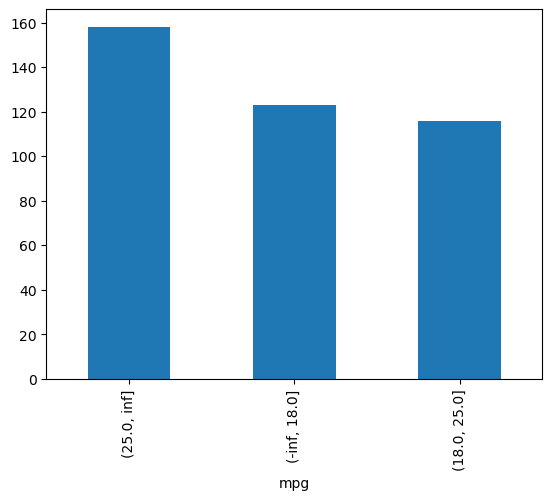

In [30]:
mpg_cat.value_counts().plot.bar()

### Feature Summarization versus Feature Transformation
The `pd.cut` function is different from the other functions (or methods) we learned about so far. The `describe`, `mean`, `quantile`, or `value_counts` functions are **feature summarization** functions, but `pd.cut` is a **feature transformation** function, meaning that not only its input, but also its output are features. In the above example, the input to `pd.cut` was `mpg`, and the output was the `mpg_cat` which we chose to append to the data as a new column, but could have also stored in a separate variable. Storing it as a separate variable is a good idea if the variable stores some intermediate values that we use as part of a transformation but don't need anymore afterwards. 

### End of exercise

## Working with categorical data

Let's now look at common tasks for treating **categorical data** prior to modeling. Categorical data needs a lot of attention during data pre-processing. This is because most machine learning algorithms don't deal directly with categorical data. Instead we need to **recode** the data from categorical into numeric, and we will see how we do that in this notebook.

Let's begin by reading some data. We will use a marketing data set of bank customers. You can read more about the data [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). 

In [31]:
import pandas as pd
import numpy as np

bank = pd.read_csv('../../data/bank-full.csv', sep = ";")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


We can see that our data contains many categorical columns, including the target itself. Let's check the data types:

In [32]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


We can use the `select_dtypes` method to limit the data to just the categorical columns.

In [33]:
bank.select_dtypes('object').head() # bank.loc[:, bank.dtypes == 'object'].head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,no
4,unknown,single,unknown,no,no,no,unknown,may,unknown,no


It turns out there are **two kinds of data types for categorical data** in `pandas`: `object` and `category`. By default, any non-numeric column will inherit the `object` type, but we can later convert it to `category` type. An `object` column type can be modified at will, but a `catogory` type is only appropriate for a column with **a limited number pre-defined categories**. This is because the `category` type is a more rigid data type with additional limitations on what they can store. So this only makes sense when the categories are known and few. Let's illustrate that by turning some of the columns in our data into a `category` columns.

In [34]:
cat_cols = ['marital', 'default', 'housing', 'loan']
bank[cat_cols] = bank[cat_cols].astype('category')

Why would we want to add additional rigidity? Because this way we can impose some amount of **data integrity**. For example, if `marital` should always be limited to "single", "divorced" or "married" then by converting `marital` into a `category` column we can prevent the data from introducing any other category without first adding it as one of the acceptable categories for this column.

In [35]:
bank['marital'].cat.categories

Index(['divorced', 'married', 'single'], dtype='object')

### Exercise (6 minutes)

- Try to change the `marital` column at the second row to the value "widowed". You should get an error.

In [36]:
print('Is widowed a category in the marital column?  ', 'widowed' in bank['marital'].cat.categories)
# Uncomment the following line of code:
# bank.loc[1, 'marital'] = "widowed"

Is widowed a category in the marital column?   False


- To fix the error, you need to add "widowed" as one of the acceptable categories. Use the `cat.add_categories` method to add "widowed" as a category and then try again to make sure you don't get an error this time.

In [37]:
# Add code here 012
bank['marital'] = bank['marital'].cat.add_categories('widowed')
bank.loc[1,'marital'] = 'widowed'
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,widowed,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


- Undo your change by reassigning the `marital` column at the second row to the value "single". Get a count of unique values for `marital` now. Do you notice anything? Explain what and why?

In [38]:
# Add code here 013
bank.loc[1,'marital'] = 'single'

Categorical columns have other useful methods, and their names speak for themselves, such as
`as_ordered`, `as_unordered`, `remove_categories`, `remove_unused_categories`, `rename_categories`, `reorder_categories`, and `set_categories`. It is important to be aware of this functionality and use it when it makes sense. Of course an alternative to using these is to convert the column back to `object` and make all the changes we want and then turn it back into `category`, but using the above methods makes the code "cleaner".

So we saw that a `category` column has pre-defined categories and a set of methods specific to itself for changing the categories, whereas an `object` column is more a type of **free-form** column where any value is acceptable. One way the above distinction matters if when we need to rename the categories for a categorical column. Changing the categories of a categorical column is an example of **recoding** or **remapping**.

- Let's first begin with an example using `job`, which has type `object`. Rename the category "management" to "managerial". HINT: find all rows where `job` is the string `'management'`, and use `loc` to change those rows to the string `'managerial'`.

In [39]:
# Add code here 014
bank.loc[bank.job == 'management', 'job'] = 'managerial'

The above approach works fine, but it's tedious if we have a lot of changes we want to make. The better way to do it is to create a Python dictionary that maps old values (values we want to change) to new values, then use the `replace` method to replace them all at once.

- Create such a dictionary and use `replace` to make the following changes in the `job` column:

  - rename `'student'` to `'in-school'`
  - consolidate `'housemaid'` and `'services'` into a single group called `'catering'`
  - change `unknown` to a missing value, i.e. `np.NaN` (without quotes)

In [40]:
# Add code here 015
ReplacementMap = {'student':'in-school', 'housemaid':'catering', 'services':'catering', "unknown":np.nan}
bank.job.replace(ReplacementMap, inplace = True)

/var/folders/_l/9c97q4ms35gg7r1hrlmv00cr0000ng/T/ipykernel_3828/4232998539.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bank.job.replace(ReplacementMap, inplace = True)


- The above transformation was a renaming and a consolidation (grouping, binning) of catgories!

- Get a count of unique values for `job` to make sure everything worked. Note that `value_counts()` does not provide count for missing values by default. We need to specify `dropna = False` to include missing vaules in the count.

In [41]:
# Add code here 016
bank.job.value_counts(dropna = False)

job
blue-collar      9732
managerial       9458
technician       7597
catering         5394
admin.           5171
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
in-school         938
NaN               288
Name: count, dtype: int64

### End of exercise

The `replace` method works equally well with a column of type `category`, however **it changes its type to `object`!** So either we have to convert it back to `category`, or we need to use the `rename_categories` method to replace values, which workes very similarly to `replace`. Here's an example:

In [42]:
bank['marital'] = bank['marital'].cat.rename_categories({'married': 'taken'})
bank['marital'].value_counts()

marital
taken       27214
single      12790
divorced     5207
widowed         0
Name: count, dtype: int64

Categorical columns can also be easily generated from numeric columns. For example, let's say we want to have a column called `high_balance` that is `True` when balance exceeds $2,000 and `False` otherwise. Technically this would be a boolean column, but in practice it acts as categorical column. Generating such a column is very easy. We refer to such binary colums as **dummy variables** or **flags** because they single out a group.

In [43]:
bank['high_balance'] = bank['balance'] > 2000

In [44]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,high_balance
0,58,managerial,taken,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,True
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,False
2,33,entrepreneur,taken,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,False
3,47,blue-collar,taken,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,False
4,33,NaN,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,False


The process of creating a dummy variable **for each category** of a categorical feature is called **one-hot encoding**. Let's see what happens if we one-hot-encode `marital`.

In [45]:
bank['marital_taken'] = (bank['marital'] == 'taken').astype('int')
bank['marital_single'] = (bank['marital'] == 'single').astype('int')
bank['marital_divorced'] = (bank['marital'] == 'divorced').astype('int')

In [46]:
bank.filter(like = 'marital').head()

,marital,marital_taken,marital_single,marital_divorced
0,taken,1,0,0
1,single,0,1,0
2,taken,1,0,0
3,taken,1,0,0
4,single,0,1,0


One-hot encoding is a common enough task that we don't need to do it manually like we did above. Instead we can use `pd.get_dummies` to do it in one go.

In [47]:
pd.get_dummies(bank[['marital', 'job']], prefix = ['marital', 'job']).head()

,marital_divorced,marital_taken,marital_single,marital_widowed,job_admin.,job_blue-collar,job_catering,job_entrepreneur,job_in-school,job_managerial,job_retired,job_self-employed,job_technician,job_unemployed
0,False,True,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,False,False,True,False
2,False,True,False,False,False,False,False,True,False,False,False,False,False,False
3,False,True,False,False,False,True,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,False,False,False,False


There's an even more streamlined way to do one-hot encoding, although at first blush it appears less straight-forward, but there is a reason it is set up this way and we will explain that later. Just like normalization, one-hot-encoding is a common pre-processing task and we can turn to the `sklearn` library to do the hard part for us.

In [48]:
from sklearn.preprocessing import OneHotEncoder

bank_cat = bank.select_dtypes('category').copy() # only select columns that have type 'category'
onehot = OneHotEncoder(sparse_output = False) # initialize one-hot-encoder
onehot.fit(bank_cat)
col_names = onehot.get_feature_names_out(bank_cat.columns) # this allows us to properly name columns
bank_onehot =  pd.DataFrame(onehot.transform(bank_cat), columns = col_names)
bank_onehot.head()

,marital_divorced,marital_single,marital_taken,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


So we can see that one-hot encoding created a **binary feature** for **each category of each categorical column** in the data. Although to be more specific, we limited it to columns whose type is `category` and excluded columns whose type is `object`. This is because one-hot encoding can quickly blow up the number of columns in the data if we are not careful and include categorical columns with lots of categories (also called **high-cardinality** categorical columns). In such cases, we would one-hot encode only the top $n$ categories (what $n$ should be and what "top" should mean depends on the context). Another 

What is the point of doing this? The reason we do this is that most machine learning algorithms do not work **directly** with categorical data, so we need to encode the categorical data which turns it into numeric data. One-hot encoding is just one type of encoding, but it is the most common one.

One last note about the `sklearn` pre-processing transformations we learned about in this notebook: If you look at examples online, you may notice that instead of calling `fit` and `transform` separately, you can call `fit_transform` which combines the two steps into one. This may seem reasonable and saves you one extra line of code, but we discourage it. The following exercise will illustrate why, but the main reason will become clear when we talk about machine learning.

### Exercise (5 minutes)

We want to one-hot-encode the `education` and `month` columns in bank. 

- First create an instance of the one-hot encoder and invoke fit and transform with fit_transform using the `education` and `month` columns in bank.

In [49]:
# Add code here 017
cols = ['education','month']
binary_maker = OneHotEncoder(sparse_output=False)
binary_data = binary_maker.

SyntaxError: invalid syntax (963361078.py, line 4)

Create new "hybrid" column names for the new one-hot-encoded values.  The column names are a hybrid of the original column name and the column values.

In [ ]:
# Add code here 018

Create a new dataframe out of the one-hot-encoded values and the new column names

In [ ]:
# Add code here 019

Concatenate the new dataframe of the new one-hot-encoded columns to the original bank dataframe and then drop the original `education` and `month` columns

In [ ]:
# Add code here 020

### End of exercise

One final note about one-hot encoding: there are more sophisticated way that we can perform one-hot encoding by using hash functions. We leave the reader to read about **feature hashing** (if you know what **hash functions** are, then feature hashing is very easy to grasp). This method has the advantage that we do not need to know what the categories are ahead of time. Not only does this free us from keeping track of the categories, but it also means that we don't have to load the pre-defined list of categories with the model **at score time** when the model is deployed: We just use the hash function to compute it on the fly. This can make scoring much more efficient when the size of features is large.

# Assignment
The assignment is in **Lesson_05_b_assignment.ipynb**